In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error # 回帰問題における性能評価に関する関数
from  sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix # 回帰問題における性能評価に関する関数

import datetime as dt 
import seaborn as sns


In [2]:
df = pd.read_csv("../archive/ks-projects-201801.csv")
display(df.head())


# ・ID：クラウドファンディングの個別ID
# ・name：クラウドファンディングの名前
# ・category：詳細なカテゴリー
# ・main_category：大まかなカテゴリー
# ・currency ：使用された通貨
# ・deadline：締め切り日時
# ・goal：目標調達資金額
# ・launched：開始した日時
# ・pledged：集まった資金
# ・state：プロジェクトの状態(成功、失敗、キャンセルなど)
# ・backer：集まった支援者
# ・country：プロジェクトが開かれた国
# ・usd pledged： 集まった資金の米ドル換算

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
ID                  378661 non-null int64
name                378657 non-null object
category            378661 non-null object
main_category       378661 non-null object
currency            378661 non-null object
deadline            378661 non-null object
goal                378661 non-null float64
launched            378661 non-null object
pledged             378661 non-null float64
state               378661 non-null object
backers             378661 non-null int64
country             378661 non-null object
usd pledged         374864 non-null float64
usd_pledged_real    378661 non-null float64
usd_goal_real       378661 non-null float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB


In [4]:
df.isnull().sum()

ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64

In [5]:
#37万のデータに対して3000のデータは消しても問題ないと考えた(全体の0.8%程度)
#元データとドロップデータを分けた意味はあまりないのでは？
#次回以降要検討
df_dp = df.dropna()
df_dp.isnull().sum()

ID                  0
name                0
category            0
main_category       0
currency            0
deadline            0
goal                0
launched            0
pledged             0
state               0
backers             0
country             0
usd pledged         0
usd_pledged_real    0
usd_goal_real       0
dtype: int64

In [6]:
#開始と締切から日数を計算
#deadlineとlaunchedをobjectからdatetime型に変更
df_dp['deadline'] = pd.to_datetime(df_dp['deadline'], errors = 'coerce')
df_dp['launched'] = pd.to_datetime(df_dp['launched'], errors = 'coerce')

#締切-開始日＝日数(.dt.daysで時間を日数に変更)を新しく挿入
df_dp['period'] = (df_dp['deadline'] - df_dp['launched']).dt.days

display(df_dp.head())

C:\Users\Trick\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Trick\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\Trick\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,period
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95,58
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00,59
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00,44
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00,29
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00,55


In [7]:
#いらないデータを消す
df_dp= df_dp.drop(['ID','name','category','country','deadline','launched','currency'], axis=1)
display(df_dp.head())

#category:種類が多すぎるので消す
#country:可視化した結果いらなそうだった
#main_category:成功しやすいカテゴリがありそう（後で消すかも）

,main_category,goal,pledged,state,backers,usd pledged,usd_pledged_real,usd_goal_real,period
0,Publishing,1000.0,0.0,failed,0,0.0,0.0,1533.95,58
1,Film & Video,30000.0,2421.0,failed,15,100.0,2421.0,30000.00,59
2,Film & Video,45000.0,220.0,failed,3,220.0,220.0,45000.00,44
3,Music,5000.0,1.0,failed,1,1.0,1.0,5000.00,29
4,Film & Video,19500.0,1283.0,canceled,14,1283.0,1283.0,19500.00,55


In [8]:
df_dp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 374860 entries, 0 to 378660
Data columns (total 9 columns):
main_category       374860 non-null object
goal                374860 non-null float64
pledged             374860 non-null float64
state               374860 non-null object
backers             374860 non-null int64
usd pledged         374860 non-null float64
usd_pledged_real    374860 non-null float64
usd_goal_real       374860 non-null float64
period              374860 non-null int64
dtypes: float64(5), int64(2), object(2)
memory usage: 28.6+ MB


In [9]:
df_dp['main_category'].unique()

array(['Publishing', 'Film & Video', 'Music', 'Food', 'Design', 'Crafts',
       'Games', 'Comics', 'Fashion', 'Theater', 'Art', 'Photography',
       'Technology', 'Dance', 'Journalism'], dtype=object)

In [10]:
df_dp['state'].unique()

array(['failed', 'canceled', 'successful', 'live', 'suspended'],
      dtype=object)

In [11]:
#成功と失敗のみ残してみる
#データが減りすぎたら他の方法を検討
df_dp = df_dp[(df_dp['state'] == 'successful') | (df_dp['state'] == 'failed')]

In [12]:
df_dp['state'].unique()

array(['failed', 'successful'], dtype=object)

In [13]:
df_dp.info()

#元データの9割はありそうなので続行

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331462 entries, 0 to 378660
Data columns (total 9 columns):
main_category       331462 non-null object
goal                331462 non-null float64
pledged             331462 non-null float64
state               331462 non-null object
backers             331462 non-null int64
usd pledged         331462 non-null float64
usd_pledged_real    331462 non-null float64
usd_goal_real       331462 non-null float64
period              331462 non-null int64
dtypes: float64(5), int64(2), object(2)
memory usage: 25.3+ MB


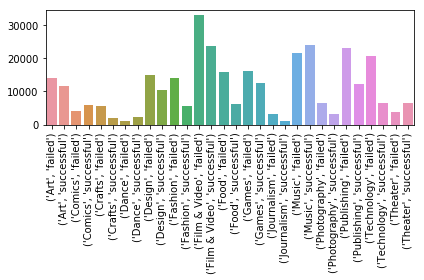

In [14]:
#何となくの可視化
data_count = df_dp.groupby(["main_category","state"])["state"].count()
sns.barplot(data_count.keys(),data_count.values)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

#main_categoryの相関はなさそう

In [15]:
df_dp= df_dp.drop(['main_category'], axis=1)

In [16]:
display(df_dp.head())

,goal,pledged,state,backers,usd pledged,usd_pledged_real,usd_goal_real,period
0,1000.0,0.0,failed,0,0.0,0.0,1533.95,58
1,30000.0,2421.0,failed,15,100.0,2421.0,30000.00,59
2,45000.0,220.0,failed,3,220.0,220.0,45000.00,44
3,5000.0,1.0,failed,1,1.0,1.0,5000.00,29
5,50000.0,52375.0,successful,224,52375.0,52375.0,50000.00,34


In [17]:
#successfulをTrueに、failedをFalseに変換
df_dp['state'] = df_dp['state'] =="successful" 
display(df_dp.head())

,goal,pledged,state,backers,usd pledged,usd_pledged_real,usd_goal_real,period
0,1000.0,0.0,False,0,0.0,0.0,1533.95,58
1,30000.0,2421.0,False,15,100.0,2421.0,30000.00,59
2,45000.0,220.0,False,3,220.0,220.0,45000.00,44
3,5000.0,1.0,False,1,1.0,1.0,5000.00,29
5,50000.0,52375.0,True,224,52375.0,52375.0,50000.00,34


In [18]:
# 相関係数を確認
df_dp.corr()

,goal,pledged,state,backers,usd pledged,usd_pledged_real,usd_goal_real,period
goal,1.000000,0.007962,-0.025096,0.004792,0.006416,0.005949,0.952614,0.022696
pledged,0.007962,1.000000,0.109562,0.718120,0.857966,0.953465,0.005716,0.008036
state,-0.025096,0.109562,1.000000,0.125848,0.095658,0.108359,-0.023732,-0.116466
backers,0.004792,0.718120,0.125848,1.000000,0.697493,0.753221,0.005207,-0.000059
usd pledged,0.006416,0.857966,0.095658,0.697493,1.000000,0.907713,0.006965,0.007718
usd_pledged_real,0.005949,0.953465,0.108359,0.753221,0.907713,1.000000,0.006349,0.008570
usd_goal_real,0.952614,0.005716,-0.023732,0.005207,0.006965,0.006349,1.000000,0.021611
period,0.022696,0.008036,-0.116466,-0.000059,0.007718,0.008570,0.021611,1.000000


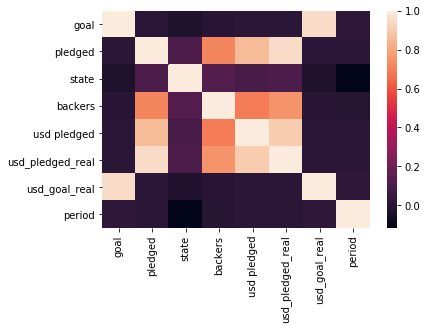

In [19]:
# 相関係数をヒートマップにして可視化
sns.heatmap(df_dp.corr())
plt.show()

In [20]:
y = df_dp["state"].values
X = df_dp.drop('state', axis=1).values

# 各特徴量を平均0，分散1となるような前処理（標準化，詳しくはDAY2にて）を施すためのクラス
# 今回のデータセットは特徴量の平均や分散がそれぞれで大きく異なるため，標準化をしないとリノベーション済み物件が１件も当てられないことが事前検証でわかっている
std_scaler = StandardScaler() 

# fit_transform関数で標準化した特徴量X_scaledを得る
# 以降はX_scaledをモデルの学習等に使う
X_scaled = std_scaler.fit_transform(X)


clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3, )
clf.fit(X_scaled, y)

# 重みを取得して表示
w0 = clf.intercept_[0]
w1 = clf.coef_[0, 0]
w2 = clf.coef_[0, 1]
w3 = clf.coef_[0, 2]
w4 = clf.coef_[0, 3]
w5 = clf.coef_[0, 4]
w6 = clf.coef_[0, 5]
w7 = clf.coef_[0, 6]
print('w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}, w3 = {:.3f}, w4 = {:.3f}, w5 = {:.3f}, w6 = {:.3f}, w7 = {:.3f}'
      .format(w0, w1, w2, w3, w4, w5, w6, w7))

w0 = -4.726, w1 = -127.730, w2 = 16.103, w3 = 19.592, w4 = -2.375, w5 = 20.294, w6 = -128.673, w7 = -0.221


In [21]:
# ラベルを予測
y_est = clf.predict(X_scaled)

# 確率値を得る
y_est_proba = clf.predict_proba(X_scaled)

# 対数尤度を表示
# log_lossという関数は、負の対数尤度を返す
# normalizeという引数をTrueにすると、合計の対数尤度ではなく平均の対数尤度が計算される
print('対数尤度 = {:.3f}'.format(- log_loss(y, y_est_proba, normalize=False))) 

# 正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y, y_est)))

対数尤度 = -84538.565
正答率 = 92.154%


In [22]:
# 予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y, y_est), 
                        index=['正解 = 失敗', '正解 = 成功'], 
                        columns=['予測 = 失敗', '予測 = 成功'])
conf_mat

,予測 = 失敗,予測 = 成功
正解 = 失敗,192531,5080
正解 = 成功,20926,112925


In [24]:
# ラベルを予測
y_pred = clf.predict(X_scaled)

# 正答率を計算
accuracy =  accuracy_score(y, y_pred)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_pred)

# Precision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[1]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[1]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[1]))

正答率（Accuracy） = 92.154%
適合率（Precision） = 95.695%
再現率（Recall） = 84.366%
F1値（F1-score） = 89.674%


In [23]:
# 参考文献
#短縮URL　https://qr.paps.jp/60vCT
# 一応元のやつ　https://ds-blog.tbtech.co.jp/entry/2019/04/19/Kaggle%E3%81%AB%E6%8C%91%E6%88%A6%E3%81%97%E3%82%88%E3%81%86%EF%BC%81_%EF%BD%9E%E3%82%B3%E3%83%BC%E3%83%89%E8%AA%AC%E6%98%8E%EF%BC%91%EF%BD%9E